# Kernel-based Time-varying Regression - Part III

The tutorials **I** and  **II** described the **KTR** model, its fitting procedure, visualizations and diagnostics / validation methods . This tutorial covers more **KTR** configurations for advanced users. In particular, it describes how to use knots to model change points in the seasonality and regression coefficients.

For more detail on this see Ng, Wang and Dai (2021)., which describes how **KTR** knots can be thought of as change points. This highlights a similarity between  **KTR** and **Facebook’s Prophet** package which introduces the change point detection on levels.

**Part III** covers different **KTR** arguments to specify knots position:

- `level_segements`
- `level_knot_distance`
- `level_knot_dates`


In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.plot import get_orbit_style
from orbit.utils.dataset import load_iclaims

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
print(orbit.__version__)

1.1.3


## Fitting with iClaims Data

The iClaims data set gives the weekly log number of claims and several regressors. 

In [3]:
# without the endate, we would get end date='2018-06-24' to make our tutorial consistent with the older version
df = load_iclaims(end_date='2020-11-29')

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)
df.head()

(570, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.03493,-0.34414,0.12802,-0.53745,0.08456
1,2010-01-10,13.62422,0.03493,-0.22053,0.17932,-0.54529,0.07235
2,2010-01-17,13.39874,0.05119,-0.31817,0.12802,-0.58504,0.49424
3,2010-01-24,13.13755,0.01840,-0.22053,0.11744,-0.60156,0.39055
4,2010-01-31,13.19676,-0.05059,-0.26816,0.08501,-0.60874,0.44931


### Specifying Levels Segments

The first way to specify the knot locations and number is the `level_segements` argument. This gives the number of between knot segments; since there is a knot on each end of each the total number of knots would be the number of segments plus one. To illustrate that, try `level_segments=10` (line 5).

In [4]:
response_col = 'claims'
date_col='week'

In [5]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,

    level_segments=10,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    estimator='pyro-svi'
)

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 176.47, scale = 0.083093
INFO:orbit:step  100 loss = 113.12, scale = 0.046384
INFO:orbit:step  200 loss = 113.16, scale = 0.04608
INFO:orbit:step  300 loss = 113.27, scale = 0.04625


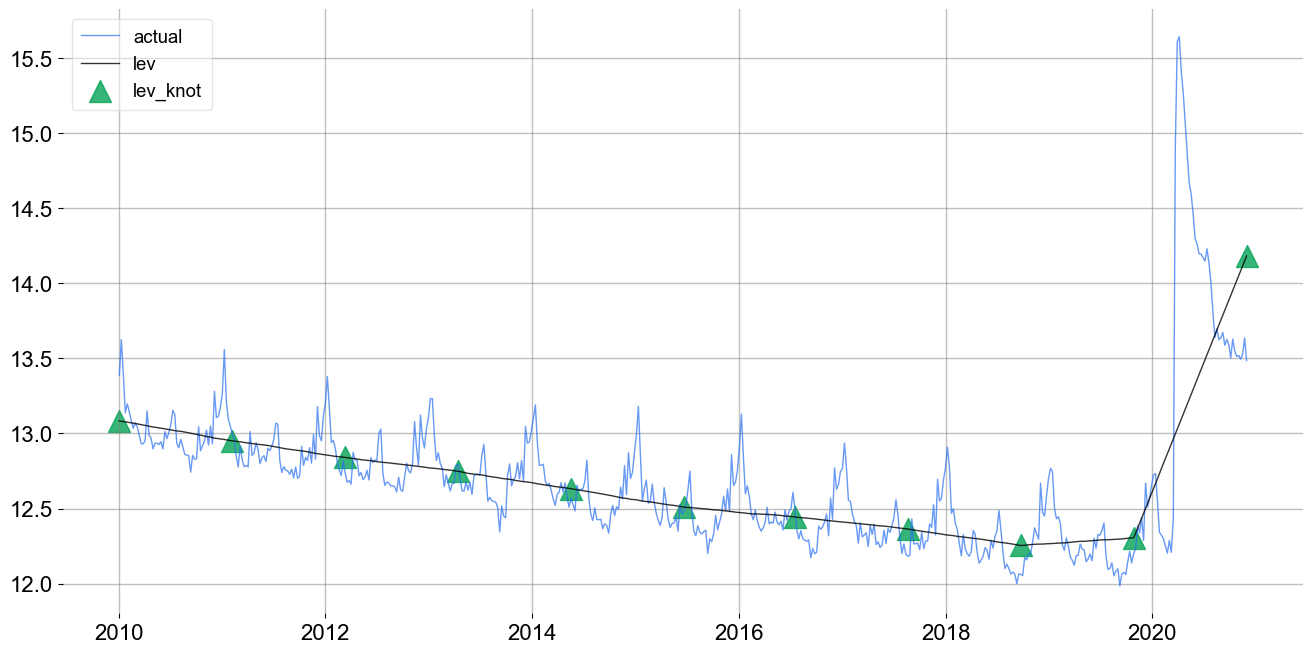

In [6]:
ktr.fit(df=df)
_ = ktr.plot_lev_knots()

Note that there are precisely there are $11$ knots (triangles) evenly spaced in the above chart.

### Specifying Knots Distance

An alternative way of specifying the number of knots is the `level_knot_distance` argument. This argument gives the distance between knots. It can be useful as number of knots grows with the length of the time-series. Note that if the total length of the time-series is not a multiple of `level_knot_distance` the first segment will have a different length. For example, in a weekly data, by putting `level_knot_distance=104` roughly means putting a knot once in two years.


In [7]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    level_knot_distance=104,
    
    # fit a weekly seasonality
    seasonality=52,
    # high order for sharp turns on each week
    seasonality_fs_order=12,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    estimator='pyro-svi'
)

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 145.63, scale = 0.088976
INFO:orbit:step  100 loss = -5.2717, scale = 0.036808
INFO:orbit:step  200 loss = -5.2295, scale = 0.037277
INFO:orbit:step  300 loss = -5.4426, scale = 0.037506


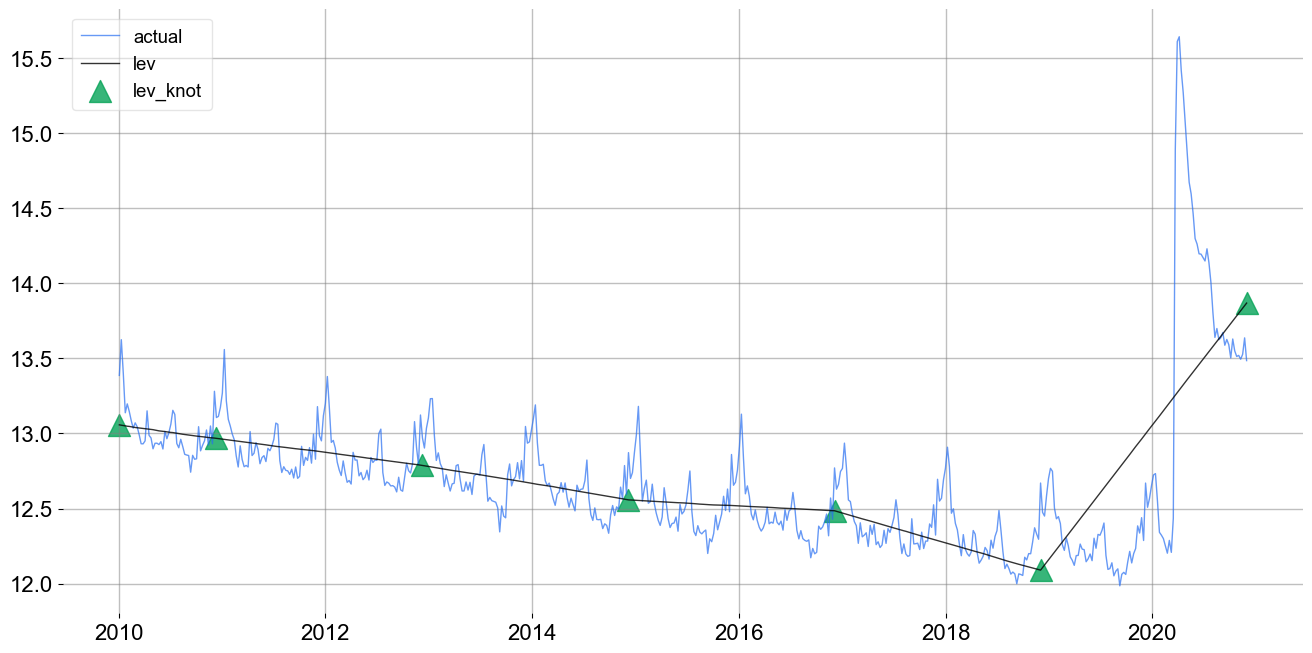

In [8]:
ktr.fit(df=df)
_ = ktr.plot_lev_knots()

In the above chart, the knots are located about every 2-years. 

To highlight the value of the next method of configuring knot position, consider the prediction for this model show below. 


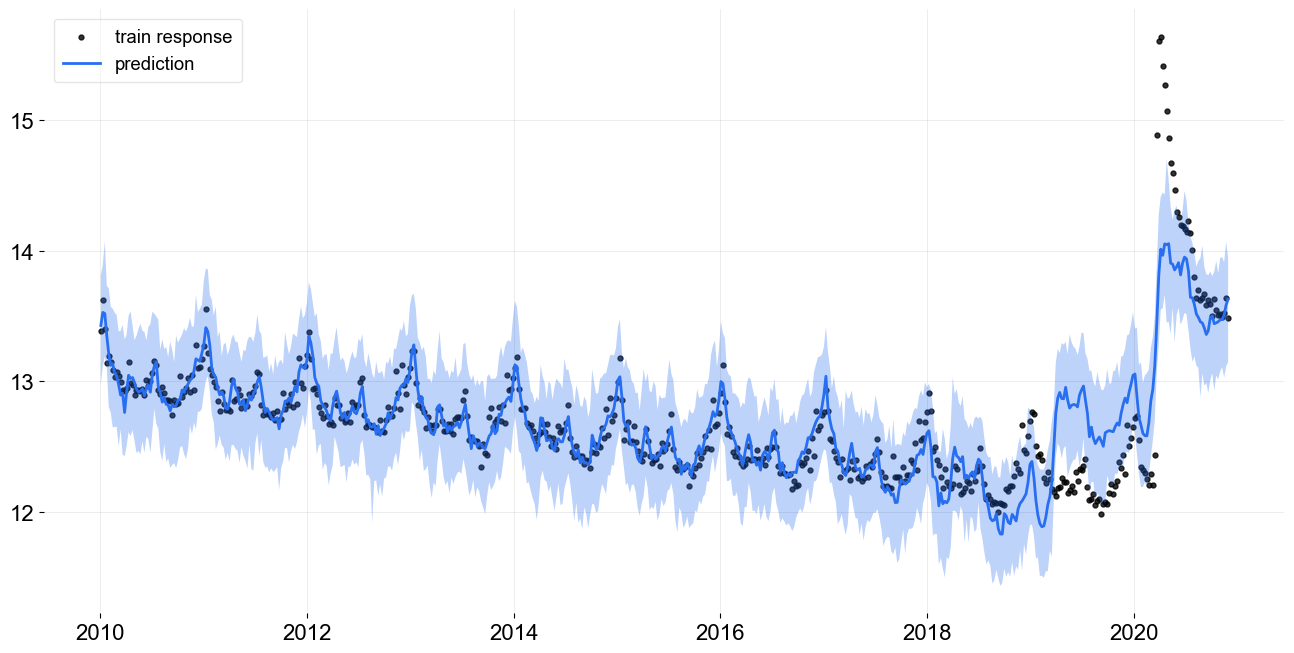

In [9]:
predicted_df = ktr.predict(df=df)
_ = plot_predicted_data(training_actual_df=df, predicted_df=predicted_df,  prediction_percentiles=[2.5, 97.5],
                        date_col=date_col, actual_col=response_col)

As the knots are placed evenly the model can not adequately describe the change point in early 2020. The model fit can potentially be improved by inserting knots around the sharp change points (e.g.,  `2020-03-15`). This insertion can be done with the `level_knot_dates` argument described below.

### Specifying Knots Dates

The `level_knot_dates` argument allows for the explicit placement of knots. It needs a string of dates; see line 4.

In [10]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    level_knot_dates =  ['2010-01-03', '2020-03-15', '2020-03-22', '2020-11-29'],
    
    # fit a weekly seasonality
    seasonality=52,
    # high order for sharp turns on each week
    seasonality_fs_order=12,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    estimator='pyro-svi'
)


In [11]:
ktr.fit(df=df)

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 99.358, scale = 0.096314
INFO:orbit:step  100 loss = -444.52, scale = 0.026774
INFO:orbit:step  200 loss = -445.8, scale = 0.027848
INFO:orbit:step  300 loss = -441.83, scale = 0.029342


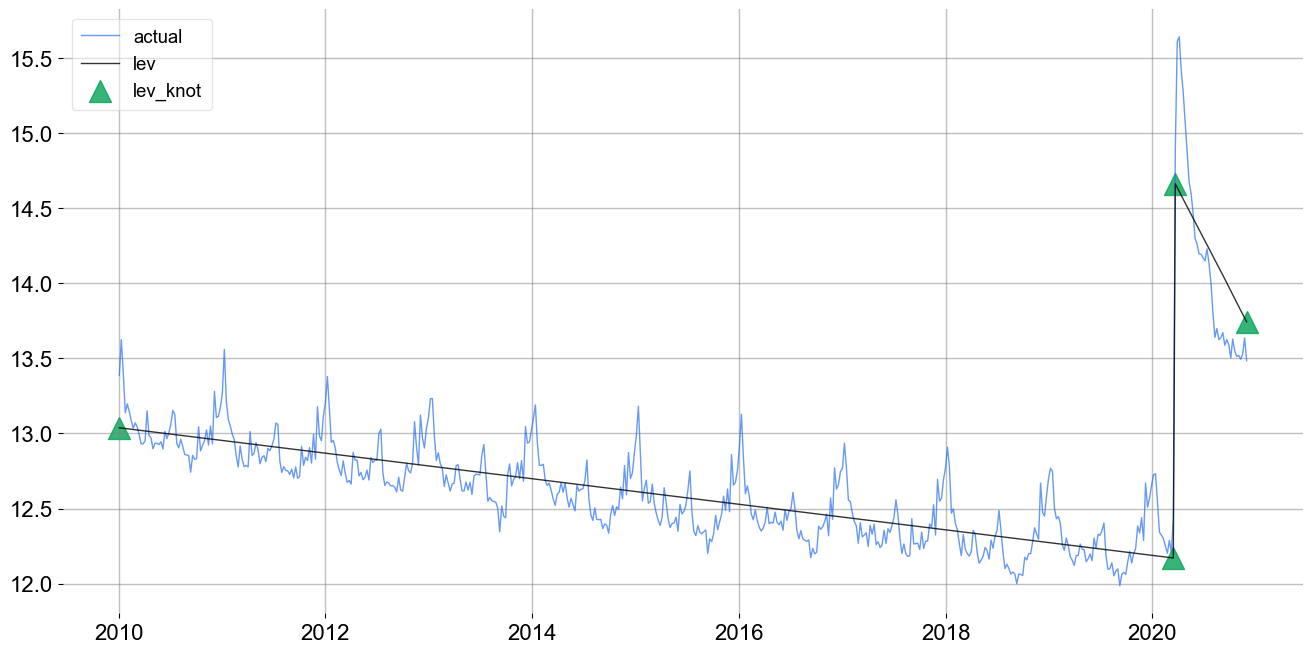

In [12]:
_ = ktr.plot_lev_knots()

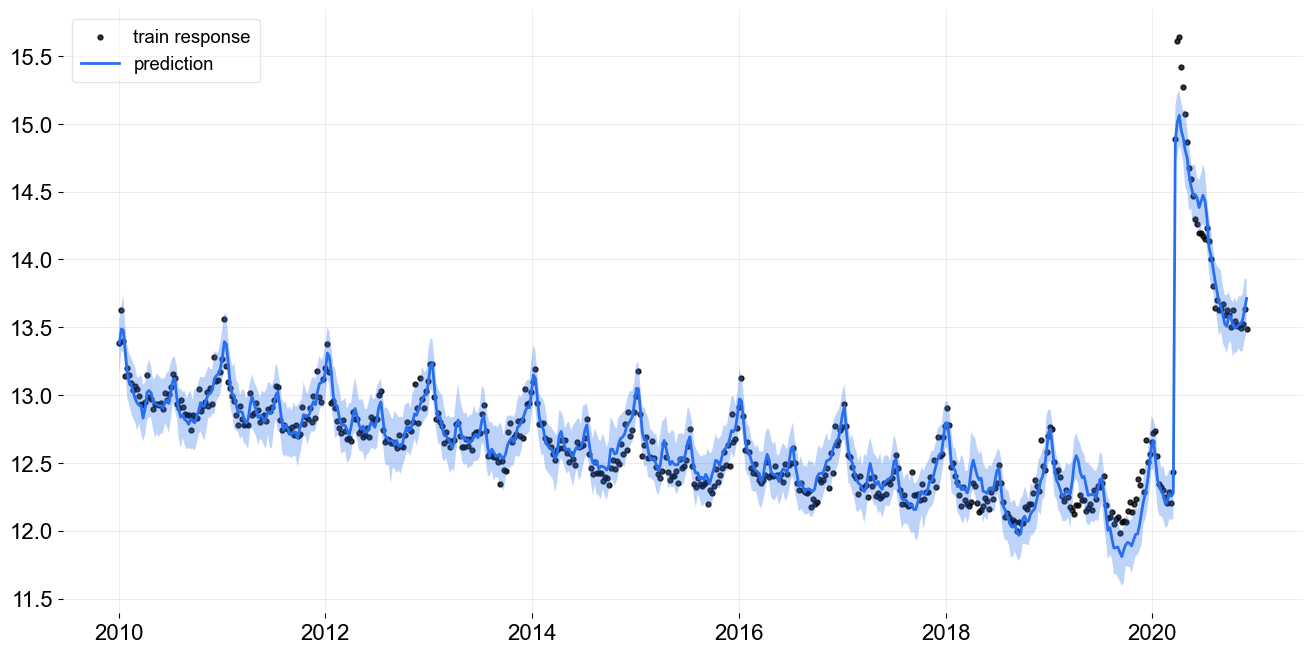

In [13]:
predicted_df = ktr.predict(df=df)
_ = plot_predicted_data(training_actual_df=df, predicted_df=predicted_df, prediction_percentiles=[2.5, 97.5],
                        date_col=date_col, actual_col=response_col)

Note this fit is even better than the previous one using less knots. Of course, the case here is trivial because the pandemic onset is treated as known. In other cases, there may not be an obvious way to find the optimal knots dates.

## Conclusion

This tutorial demonstrates multiple ways to customize the knots location for levels. In **KTR**, there are similar arguments for seasonality and regression such as `seasonality_segments` and `regression_knot_dates` and `regression_segments`.  Due to their similarities with their knots location equivalent arguments they are not demonstrated here. However it is encouraged fro **KTR** users to explore them.


## References

1. Ng, Wang and Dai (2021). Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling, arXiv preprint arXiv:2106.03322 
2. Sean J Taylor and Benjamin Letham. 2018. Forecasting at scale. The American Statistician 72, 1 (2018), 37–45. Package version 0.7.1.